# Objective:

The goal of this analysis is to understand the relationship between resignations and employee dissatisfaction within the **Department of Education, Training and Employment (DETE)** and the **Technichal and Further Education (TAFE)** institutions.

Specifically, the following relationships are explored:

    1) Length of employment vs Resignation due to dissatisfaction. 
    2) Gender vs Resignation due to dissatisfaction.
    3) Employee age vs Resignation due to dissatisfaction.
    4) Job position vs Resignation due to dissatisfaction.

Data sources:    

    https://data.gov.au/dataset/ds-qld-fe96ff30-d157-4a81-851d-215f2a0fe26d/details?q=exit%20survey (dete.csv)
    https://data.gov.au/dataset/ds-qld-89970a3b-182b-41ea-aea2-6f9f17b5907e/details?q=tafe (tafe.csv)


**Note**
Approaches to cleaning data and parsing, visualization and analysis are original, but assistance was gained from the following tutorial:
https://rstudio-pubs-static.s3.amazonaws.com/544665_30db5d1736424144bc0b833025d76b8b.html

In [1]:
# Reading in the dete_survey.csv and tafe_survey.csv files

import pandas as pd
import numpy as np
import datetime as dt
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dete = pd.read_csv("C:\\Users\\NeuroPsych\\anaconda3\\chamion\\flash\\Exit_survey_analysis\\dete_survey.csv")
tafe = pd.read_csv("C:\\Users\\NeuroPsych\\anaconda3\\chamion\\flash\\Exit_survey_analysis\\tafe_survey.csv", encoding = 'latin-1', parse_dates = True)

## DETE data snapshot

In [3]:
dete.shape

(822, 56)

In [4]:
dete.head()

,ID,SeparationType,Cease Date,DETE Start Date,Role Start Date,Position,Classification,Region,Business Unit,Employment Status,...,Kept informed,Wellness programs,Health & Safety,Gender,Age,Aboriginal,Torres Strait,South Sea,Disability,NESB
0,1,Ill Health Retirement,08/2012,1984,2004,Public Servant,A01-A04,Central Office,Corporate Strategy and Peformance,Permanent Full-time,...,N,N,N,Male,56-60,NaN,NaN,NaN,NaN,Yes
1,2,Voluntary Early Retirement (VER),08/2012,Not Stated,Not Stated,Public Servant,AO5-AO7,Central Office,Corporate Strategy and Peformance,Permanent Full-time,...,N,N,N,Male,56-60,NaN,NaN,NaN,NaN,NaN
2,3,Voluntary Early Retirement (VER),05/2012,2011,2011,Schools Officer,NaN,Central Office,Education Queensland,Permanent Full-time,...,N,N,N,Male,61 or older,NaN,NaN,NaN,NaN,NaN
3,4,Resignation-Other reasons,05/2012,2005,2006,Teacher,Primary,Central Queensland,NaN,Permanent Full-time,...,A,N,A,Female,36-40,NaN,NaN,NaN,NaN,NaN
4,5,Age Retirement,05/2012,1970,1989,Head of Curriculum/Head of Special Education,NaN,South East,NaN,Permanent Full-time,...,N,A,M,Female,61 or older,NaN,NaN,NaN,NaN,NaN


#### DETE resignation only and variables related to dissatisfaction
    

In [5]:
#Isolating "Resignation" rows of dete
dete_resignation = dete[dete['SeparationType'].str.contains('Resignation')]

In [6]:
#Dissatisfaction columns of interest
dete_dissat_var = ['ID', 'SeparationType', 'Gender', 'Age','Cease Date', 'DETE Start Date','Role Start Date', 'Position', 'Classification', 'Region',
                   'Employment Status', 'Interpersonal conflicts', 'Job dissatisfaction', 'Dissatisfaction with the department', 
                    'Physical work environment', 'Lack of recognition','Lack of job security', 'Employment conditions', 
                     'Work life balance', 'Worklife balance', 'Workload', 'Opportunities for promotion', 'Staff morale', 'Opportunities for promotion', 
                   'Stress and pressure support', 'Work location']

dete_resignation = dete_resignation[dete_dissat_var]

In [7]:
dete_resignation.shape

(311, 26)

#### Cleaning up DETE_resignation column names

In [8]:
dete_resignation.columns = dete_resignation.columns.str.lower().str.replace(" ", "_").str.strip()

In [9]:
dete_resignation.head()

,id,separationtype,gender,age,cease_date,dete_start_date,role_start_date,position,classification,region,...,lack_of_job_security,employment_conditions,work_life_balance,worklife_balance,workload,opportunities_for_promotion,staff_morale,opportunities_for_promotion,stress_and_pressure_support,work_location
3,4,Resignation-Other reasons,Female,36-40,05/2012,2005,2006,Teacher,Primary,Central Queensland,...,False,False,False,A,False,N,N,N,N,False
5,6,Resignation-Other reasons,Female,41-45,05/2012,1994,1997,Guidance Officer,NaN,Central Office,...,False,True,False,D,False,SD,SD,SD,D,False
8,9,Resignation-Other reasons,Female,31-35,07/2012,2009,2009,Teacher,Secondary,North Queensland,...,False,False,False,SD,False,N,D,N,SD,False
9,10,Resignation-Other employer,Female,46-50,2012,1997,2008,Teacher Aide,NaN,Not Stated,...,False,False,False,SD,False,SD,SD,SD,SD,False
11,12,Resignation-Move overseas/interstate,Male,31-35,2012,2009,2009,Teacher,Secondary,Far North Queensland,...,False,False,False,N,False,N,N,N,N,False


#### Adding 'dissatisfied' column to DETE_resignation based on contributing variables

In [10]:
dete_resignation['dissatisfied'] = dete_resignation[['job_dissatisfaction', 'dissatisfaction_with_the_department', 
                                                          'physical_work_environment', 'lack_of_recognition', 
                                                          'lack_of_job_security', 'work_location', 
                                                          'employment_conditions', 'work_life_balance', 
                                                          'workload']].any(axis = 1, skipna = False)

In [11]:
dete_resignation.head()

,id,separationtype,gender,age,cease_date,dete_start_date,role_start_date,position,classification,region,...,employment_conditions,work_life_balance,worklife_balance,workload,opportunities_for_promotion,staff_morale,opportunities_for_promotion,stress_and_pressure_support,work_location,dissatisfied
3,4,Resignation-Other reasons,Female,36-40,05/2012,2005,2006,Teacher,Primary,Central Queensland,...,False,False,A,False,N,N,N,N,False,False
5,6,Resignation-Other reasons,Female,41-45,05/2012,1994,1997,Guidance Officer,NaN,Central Office,...,True,False,D,False,SD,SD,SD,D,False,True
8,9,Resignation-Other reasons,Female,31-35,07/2012,2009,2009,Teacher,Secondary,North Queensland,...,False,False,SD,False,N,D,N,SD,False,False
9,10,Resignation-Other employer,Female,46-50,2012,1997,2008,Teacher Aide,NaN,Not Stated,...,False,False,SD,False,SD,SD,SD,SD,False,True
11,12,Resignation-Move overseas/interstate,Male,31-35,2012,2009,2009,Teacher,Secondary,Far North Queensland,...,False,False,N,False,N,N,N,N,False,False


In [12]:
dete_resignation.columns

Index(['id', 'separationtype', 'gender', 'age', 'cease_date',
       'dete_start_date', 'role_start_date', 'position', 'classification',
       'region', 'employment_status', 'interpersonal_conflicts',
       'job_dissatisfaction', 'dissatisfaction_with_the_department',
       'physical_work_environment', 'lack_of_recognition',
       'lack_of_job_security', 'employment_conditions', 'work_life_balance',
       'worklife_balance', 'workload', 'opportunities_for_promotion',
       'staff_morale', 'opportunities_for_promotion',
       'stress_and_pressure_support', 'work_location', 'dissatisfied'],
      dtype='object')

#### Reducing DETE_resignation further to include only needed_columns

In [13]:
#Reducing dete_resignation to needed columns
dete_resig_targetdf = dete_resignation[['id', 'gender', 'age', 'cease_date', 'dete_start_date', 'role_start_date', 'position', 'region', 'dissatisfied']]

In [14]:
#Adding a 'blank' satisfaction score column [satisfaction score can only be calculation in TAFE]
dete_resig_targetdf['satisfaction_score'] = np.nan

C:\Users\NeuroPsych\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
dete_resig_targetdf.shape

(311, 10)

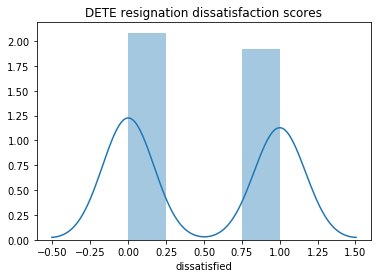

In [42]:
sns.distplot(dete_resig_targetdf.dissatisfied)
plt.title("DETE resignation dissatisfaction scores");

Among those who resigned from DETE, there are almost as many who are satisfied as those who are dissatisfied with their employment. A few more respondents are satisfied.

## TAFE data snapshot

In [17]:
tafe.shape

(702, 72)

In [18]:
tafe.head()

,Record ID,Institute,WorkArea,CESSATION YEAR,Reason for ceasing employment,Contributing Factors. Career Move - Public Sector,Contributing Factors. Career Move - Private Sector,Contributing Factors. Career Move - Self-employment,Contributing Factors. Ill Health,Contributing Factors. Maternity/Family,...,Workplace. Topic:Does your workplace promote a work culture free from all forms of unlawful discrimination?,Workplace. Topic:Does your workplace promote and practice the principles of employment equity?,Workplace. Topic:Does your workplace value the diversity of its employees?,Workplace. Topic:Would you recommend the Institute as an employer to others?,Gender. What is your Gender?,CurrentAge. Current Age,Employment Type. Employment Type,Classification. Classification,LengthofServiceOverall. Overall Length of Service at Institute (in years),LengthofServiceCurrent. Length of Service at current workplace (in years)
0,634133009996094000,Southern Queensland Institute of TAFE,Non-Delivery (corporate),2010.0,Contract Expired,NaN,NaN,NaN,NaN,NaN,...,Yes,Yes,Yes,Yes,Female,26  30,Temporary Full-time,Administration (AO),1-2,1-2
1,634133654064531000,Mount Isa Institute of TAFE,Non-Delivery (corporate),2010.0,Retirement,-,-,-,-,-,...,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN
2,634138845606563000,Mount Isa Institute of TAFE,Delivery (teaching),2010.0,Retirement,-,-,-,-,-,...,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN
3,634139903350000000,Mount Isa Institute of TAFE,Non-Delivery (corporate),2010.0,Resignation,-,-,-,-,-,...,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN
4,634146578511788000,Southern Queensland Institute of TAFE,Delivery (teaching),2010.0,Resignation,-,Career Move - Private Sector,-,-,-,...,Yes,Yes,Yes,Yes,Male,41  45,Permanent Full-time,Teacher (including LVT),3-4,3-4


TAFE column names need significant cleaning up and simplification.

#### Rebuilding TAFE df, filtering out Resignation only columns

In [19]:
tafe_resignation = tafe[tafe['Reason for ceasing employment'] == 'Resignation']

#### Isolating variables related to dissatisfaction

Column indices correspond to the following column names:

        Record ID 
        Institute 
        WorkArea 
        CESSATION YEAR
        Reason for ceasing employment
        Contributing Factors. Dissatisfaction
        Contributing Factors. Job Dissatisfaction
        Contributing Factors. Interpersonal Conflict
        InstituteViews (topics:1 --> 13)
        WorkUnitviews (topics:14 --> 30)
        Workplace (topics 5x)
        Gender
        Age 
        EmploymentType
        Classification
        LengthofServiceOverall
        LengthofServiceCurrent
    
    
    

In [20]:
indx = [0,1,2,3,4,10,11,12,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,61,62,63,64,65,66,67,68,69,70,71]


In [21]:
build_df = pd.DataFrame()
def create_df(df, build_df, indx):   
    """Function to build a df by concatenating indexed columns."""
    for i in indx:
        
        build_df = pd.concat([build_df, df.iloc[:,i]], axis = 1)
    return build_df
        

In [22]:
tafe_resig_subset = create_df(tafe_resignation, build_df, indx)

In [23]:
tafe_resig_subset.head()

,Record ID,Institute,WorkArea,CESSATION YEAR,Reason for ceasing employment,Contributing Factors. Dissatisfaction,Contributing Factors. Job Dissatisfaction,Contributing Factors. Interpersonal Conflict,InstituteViews. Topic:1. I feel the senior leadership had a clear vision and direction,InstituteViews. Topic:2. I was given access to skills training to help me do my job better,...,Workplace. Topic:Does your workplace promote a work culture free from all forms of unlawful discrimination?,Workplace. Topic:Does your workplace promote and practice the principles of employment equity?,Workplace. Topic:Does your workplace value the diversity of its employees?,Workplace. Topic:Would you recommend the Institute as an employer to others?,Gender. What is your Gender?,CurrentAge. Current Age,Employment Type. Employment Type,Classification. Classification,LengthofServiceOverall. Overall Length of Service at Institute (in years),LengthofServiceCurrent. Length of Service at current workplace (in years)
3,634139903350000000,Mount Isa Institute of TAFE,Non-Delivery (corporate),2010.0,Resignation,-,-,-,Agree,Agree,...,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN
4,634146578511788000,Southern Queensland Institute of TAFE,Delivery (teaching),2010.0,Resignation,-,-,-,Agree,Agree,...,Yes,Yes,Yes,Yes,Male,41  45,Permanent Full-time,Teacher (including LVT),3-4,3-4
5,634147506906311000,Southern Queensland Institute of TAFE,Delivery (teaching),2010.0,Resignation,-,-,-,Neutral,Neutral,...,NaN,NaN,NaN,NaN,Female,56 or older,Contract/casual,Teacher (including LVT),7-10,7-10
6,634152007975694000,Barrier Reef Institute of TAFE,Non-Delivery (corporate),2010.0,Resignation,-,-,-,Strongly Agree,Strongly Agree,...,Yes,Yes,Yes,Yes,Male,20 or younger,Temporary Full-time,Administration (AO),3-4,3-4
7,634153745310374000,Southern Queensland Institute of TAFE,Delivery (teaching),2010.0,Resignation,-,-,-,Disagree,Agree,...,Yes,Yes,Yes,No,Male,46  50,Permanent Full-time,Teacher (including LVT),3-4,3-4


In [24]:
tafe_resig_subset.shape

(340, 49)

#### Cleaning up TAFE_resig_subset column names

In [25]:
col_name_change = ['id', 'institute', 'work_area', 'cessation_yr', 'reason_leaving', 'dissatisfaction', 'job_dissatisfaction',
                 'interpersonal_conflict', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 
                  'topic9', 'topic10', 'topic11', 'topic12', 'topic13', 'topic14', 'topic15', 'topic16', 'topic17', 'topic18', 
                  'topic19', 'topic20', 'topic21', 'topic22', 'topic23', 'topic24', 'topic25', 'topic26', 'topic27', 'topic28', 
                  'topic29', 'topic30','workplace1', 'workplace2', 'workplace3', 'workplace4', 'workplace5', 'gender','age', 'employment_type',
                  'classification', 'len_svc_overall', 'len_svc_currjob']
            
                 

In [26]:
tafe_resig_subset.columns = col_name_change

In [27]:
tafe_resig_subset.head()

,id,institute,work_area,cessation_yr,reason_leaving,dissatisfaction,job_dissatisfaction,interpersonal_conflict,topic1,topic2,...,workplace2,workplace3,workplace4,workplace5,gender,age,employment_type,classification,len_svc_overall,len_svc_currjob
3,634139903350000000,Mount Isa Institute of TAFE,Non-Delivery (corporate),2010.0,Resignation,-,-,-,Agree,Agree,...,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN
4,634146578511788000,Southern Queensland Institute of TAFE,Delivery (teaching),2010.0,Resignation,-,-,-,Agree,Agree,...,Yes,Yes,Yes,Yes,Male,41  45,Permanent Full-time,Teacher (including LVT),3-4,3-4
5,634147506906311000,Southern Queensland Institute of TAFE,Delivery (teaching),2010.0,Resignation,-,-,-,Neutral,Neutral,...,NaN,NaN,NaN,NaN,Female,56 or older,Contract/casual,Teacher (including LVT),7-10,7-10
6,634152007975694000,Barrier Reef Institute of TAFE,Non-Delivery (corporate),2010.0,Resignation,-,-,-,Strongly Agree,Strongly Agree,...,Yes,Yes,Yes,Yes,Male,20 or younger,Temporary Full-time,Administration (AO),3-4,3-4
7,634153745310374000,Southern Queensland Institute of TAFE,Delivery (teaching),2010.0,Resignation,-,-,-,Disagree,Agree,...,Yes,Yes,Yes,No,Male,46  50,Permanent Full-time,Teacher (including LVT),3-4,3-4


In [28]:
tafe_resig_subset.shape

(340, 49)

#### Converting  InstituteViews and WorkUnitviews TOPIC (1-->30) columns to boolean 

In [29]:
def boolean_topics(element):
    """Changing values in topic1 --> topic30 to boolean."""
    if pd.isnull(element):
        return np.nan
    elif element == 'Neutral' or element == "Not Applicable":
        return 0
    elif element == 'Agree'  or element == 'Strongly Agree':
        return 1
    elif element == 'Disagree' or element == "Strongly Disagree":
        return -1
    

In [30]:
topic_cols = ['topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 
                  'topic9', 'topic10', 'topic11', 'topic12', 'topic13', 'topic14', 'topic15', 'topic16', 'topic17', 'topic18', 
                  'topic19', 'topic20', 'topic21', 'topic22', 'topic23', 'topic24', 'topic25', 'topic26', 'topic27', 'topic28', 
                  'topic29', 'topic30']

tafe_resig_subset[topic_cols] = tafe_resig_subset[topic_cols].applymap(boolean_topics)


#### Converting Workplace columns (5) to boolean

In [31]:
def boolean_workplace(element):
    """Changing values in workplace1 to workplace5 to boolean."""
    if pd.isnull(element):
        return np.nan
    elif element == 'Yes':
        return 1
    elif element == 'No':
        return -1

In [32]:
tafe_resig_subset[['workplace1', 'workplace2', 'workplace3', 'workplace4', 'workplace5']] = tafe_resig_subset[['workplace1', 'workplace2', 'workplace3', 'workplace4', 'workplace5']].applymap(boolean_workplace)

#### Creating a 'satisfaction_score' column in tafe_resig_subset by summing all satisfaction columns

In [33]:
tafe_resig_subset['satisfaction_score'] = tafe_resig_subset[['topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 
                  'topic9', 'topic10', 'topic11', 'topic12', 'topic13', 'topic14', 'topic15', 'topic16', 'topic17', 'topic18', 
                  'topic19', 'topic20', 'topic21', 'topic22', 'topic23', 'topic24', 'topic25', 'topic26', 'topic27', 'topic28', 
                  'topic29', 'topic30', 'workplace1', 'workplace2', 'workplace3', 'workplace4', 'workplace5']].sum(axis = 1, skipna = True)

In [34]:
tafe_resig_subset.head()

,id,institute,work_area,cessation_yr,reason_leaving,dissatisfaction,job_dissatisfaction,interpersonal_conflict,topic1,topic2,...,workplace3,workplace4,workplace5,gender,age,employment_type,classification,len_svc_overall,len_svc_currjob,satisfaction_score
3,634139903350000000,Mount Isa Institute of TAFE,Non-Delivery (corporate),2010.0,Resignation,-,-,-,1.0,1.0,...,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0
4,634146578511788000,Southern Queensland Institute of TAFE,Delivery (teaching),2010.0,Resignation,-,-,-,1.0,1.0,...,1.0,1.0,1.0,Male,41  45,Permanent Full-time,Teacher (including LVT),3-4,3-4,35.0
5,634147506906311000,Southern Queensland Institute of TAFE,Delivery (teaching),2010.0,Resignation,-,-,-,0.0,0.0,...,NaN,NaN,NaN,Female,56 or older,Contract/casual,Teacher (including LVT),7-10,7-10,0.0
6,634152007975694000,Barrier Reef Institute of TAFE,Non-Delivery (corporate),2010.0,Resignation,-,-,-,1.0,1.0,...,1.0,1.0,1.0,Male,20 or younger,Temporary Full-time,Administration (AO),3-4,3-4,33.0
7,634153745310374000,Southern Queensland Institute of TAFE,Delivery (teaching),2010.0,Resignation,-,-,-,-1.0,1.0,...,1.0,1.0,-1.0,Male,46  50,Permanent Full-time,Teacher (including LVT),3-4,3-4,-5.0


In [35]:
tafe_resig_subset.satisfaction_score.shape

(340,)

#### Creating a 'dissatisfied' column from 2 dissatisfaction columns

In [36]:
def update_dissat(element):
    if pd.isnull(element):
        return np.nan
    elif element == '-':
        return False
    else:
        return True

In [37]:
tafe_resig_subset[['dissatisfaction', 'job_dissatisfaction']] = tafe_resig_subset[['dissatisfaction', 'job_dissatisfaction']].applymap(update_dissat)
tafe_resig_subset['dissatisfied'] = tafe_resig_subset[['dissatisfaction', 'job_dissatisfaction']].any(axis = 1, skipna =  False)



In [38]:
tafe_resig_subset.head()

,id,institute,work_area,cessation_yr,reason_leaving,dissatisfaction,job_dissatisfaction,interpersonal_conflict,topic1,topic2,...,workplace4,workplace5,gender,age,employment_type,classification,len_svc_overall,len_svc_currjob,satisfaction_score,dissatisfied
3,634139903350000000,Mount Isa Institute of TAFE,Non-Delivery (corporate),2010.0,Resignation,False,False,-,1.0,1.0,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,False
4,634146578511788000,Southern Queensland Institute of TAFE,Delivery (teaching),2010.0,Resignation,False,False,-,1.0,1.0,...,1.0,1.0,Male,41  45,Permanent Full-time,Teacher (including LVT),3-4,3-4,35.0,False
5,634147506906311000,Southern Queensland Institute of TAFE,Delivery (teaching),2010.0,Resignation,False,False,-,0.0,0.0,...,NaN,NaN,Female,56 or older,Contract/casual,Teacher (including LVT),7-10,7-10,0.0,False
6,634152007975694000,Barrier Reef Institute of TAFE,Non-Delivery (corporate),2010.0,Resignation,False,False,-,1.0,1.0,...,1.0,1.0,Male,20 or younger,Temporary Full-time,Administration (AO),3-4,3-4,33.0,False
7,634153745310374000,Southern Queensland Institute of TAFE,Delivery (teaching),2010.0,Resignation,False,False,-,-1.0,1.0,...,1.0,-1.0,Male,46  50,Permanent Full-time,Teacher (including LVT),3-4,3-4,-5.0,False


#### Taking a peek into what TAFE data indicates regarding satisfaction_score vs dissatisfaction

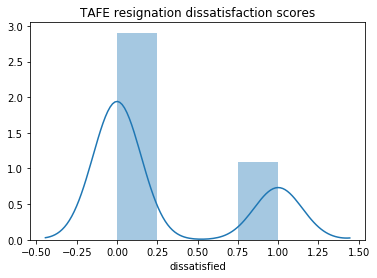

In [46]:
import seaborn as sns
sns.distplot(tafe_resig_subset.dissatisfied)
plt.title('TAFE resignation dissatisfaction scores');

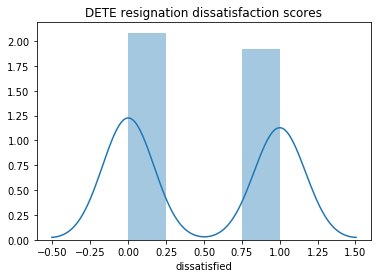

In [44]:
sns.distplot(dete_resig_targetdf.dissatisfied)
plt.title("DETE resignation dissatisfaction scores");

Comparing dissatifaction scores from DETE (plot shown earlier) and TAFE, we can see that TAFE respondents who resigned are generally more satisfied with their employment than those from DETE institution.

### A peak into TAFE satisfaction scores

Text(0.5, 1.0, 'TAFE satisfaction scores')

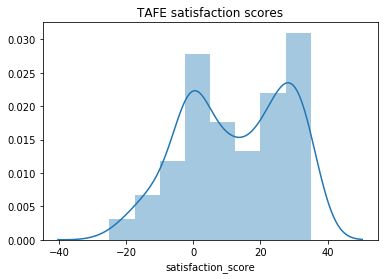

In [213]:
#Alternatively, TAFE satisfaction scores
sns.distplot(tafe_resig_subset.satisfaction_score)
plt.title('TAFE satisfaction scores')

Satisfaction scores range from -35 (very dissatisfied) to 35 (very satisfied). More than 50% of resigned respondents have neutral to high satisfaction scores. 

In [91]:
dete_resig_targetdf.columns

Index(['id', 'gender', 'age', 'cease_date', 'dete_start_date',
       'role_start_date', 'position', 'region', 'dissatisfied',
       'satisfaction_score', 'institute'],
      dtype='object')

#### Reducing TAFE_resig_subset to only target variables related to dissatisfaction before joining DETE and TAFE

In [47]:
#Reducing tafe_resignation to necessary target columns
tafe_resignation_targetdf = tafe_resig_subset[['id','cessation_yr', 'dissatisfied', 'gender', 'age', 'len_svc_overall', 'len_svc_currjob', 'satisfaction_score']]

## Combining dete_resig_targetdf and tafe_resignation_targetdf

In [92]:
dete_resig_targetdf['institute'] = 'DETE'
tafe_resignation_targetdf['institute'] = 'TAFE'
resignation_df = pd.concat([dete_resig_targetdf,tafe_resignation_targetdf], ignore_index = True, sort = False)

C:\Users\NeuroPsych\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\NeuroPsych\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [93]:
resignation_df.tail()

,id,gender,age,cease_date,dete_start_date,role_start_date,position,region,dissatisfied,satisfaction_score,institute,cessation_yr,len_svc_overall,len_svc_currjob
646,635065973820625000,Male,21  25,NaN,NaN,NaN,NaN,NaN,False,23.0,TAFE,2013.0,5-6,5-6
647,635066785175197000,Male,51-55,NaN,NaN,NaN,NaN,NaN,False,20.0,TAFE,2013.0,1-2,1-2
648,635067716405666000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0,TAFE,2013.0,NaN,NaN
649,635070442972541000,Female,51-55,NaN,NaN,NaN,NaN,NaN,False,33.0,TAFE,2013.0,5-6,1-2
650,635073030973791000,Female,26  30,NaN,NaN,NaN,NaN,NaN,False,31.0,TAFE,2013.0,3-4,1-2


In [94]:
resignation_df.shape

(651, 14)

## Renaming 'dete_start_date'  column as 'start_date'

In [95]:
resignation_df.rename(columns = {'dete_start_date' :'start_date'}, inplace = True)

## Cleaning up 'age' column

In [96]:
resignation_df.age.value_counts()

51-55            71
41-45            48
41  45          45
46-50            42
36-40            41
46  50          39
26-30            35
21  25          33
36  40          32
26  30          32
31  35          32
31-35            29
56 or older      29
21-25            29
56-60            26
61 or older      23
20 or younger    10
Name: age, dtype: int64

In [97]:
resignation_df.age[resignation_df.age == '41  45'] = '41-45'
resignation_df.age[resignation_df.age == '46  50'] = '46-50'
resignation_df.age[resignation_df.age == '21  25'] = '21-25'
resignation_df.age[resignation_df.age == '31  35'] = '31-35'
resignation_df.age[resignation_df.age == '36  40'] = '36-40'
resignation_df.age[resignation_df.age == '26  30'] = '26-30'
resignation_df.age[resignation_df.age == '56 or older'] = '56+'
resignation_df.age[resignation_df.age == '56-60'] = '56+'
resignation_df.age[resignation_df.age == '61 or older'] = '56+'
resignation_df.age[resignation_df.age == '20 or younger'] = '<20'

C:\Users\NeuroPsych\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\NeuroPsych\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\NeuroPsych\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykern

In [98]:
resignation_df.age.value_counts().sort_values()

<20      10
31-35    61
21-25    62
26-30    67
51-55    71
36-40    73
56+      78
46-50    81
41-45    93
Name: age, dtype: int64

## Cleaning up 'cease_date' column and extracting 'cease_yr'

In [99]:
resignation_df.cease_date.value_counts()

2012          126
2013           74
01/2014        22
12/2013        17
06/2013        14
Not Stated     11
09/2013        11
11/2013         9
07/2013         9
10/2013         6
08/2013         4
05/2012         2
05/2013         2
07/2012         1
2010            1
07/2006         1
09/2010         1
Name: cease_date, dtype: int64

In [100]:
resignation_df.cease_date[resignation_df.cease_date == 'Not Stated'] = np.nan
resignation_df['cease_yr'] = resignation_df.cease_date.str.extract('(20[0-9]{2})')

C:\Users\NeuroPsych\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [101]:
resignation_df.head()

,id,gender,age,cease_date,start_date,role_start_date,position,region,dissatisfied,satisfaction_score,institute,cessation_yr,len_svc_overall,len_svc_currjob,cease_yr
0,4,Female,36-40,05/2012,2005,2006,Teacher,Central Queensland,False,NaN,DETE,NaN,NaN,NaN,2012
1,6,Female,41-45,05/2012,1994,1997,Guidance Officer,Central Office,True,NaN,DETE,NaN,NaN,NaN,2012
2,9,Female,31-35,07/2012,2009,2009,Teacher,North Queensland,False,NaN,DETE,NaN,NaN,NaN,2012
3,10,Female,46-50,2012,1997,2008,Teacher Aide,Not Stated,True,NaN,DETE,NaN,NaN,NaN,2012
4,12,Male,31-35,2012,2009,2009,Teacher,Far North Queensland,False,NaN,DETE,NaN,NaN,NaN,2012


## Changing 'Not Stated' to null and removing error year from 'start_date' col

In [102]:
resignation_df.start_date.value_counts()

Not Stated    28
2011          24
2008          22
2012          21
2007          21
2010          17
2005          15
2004          14
2009          13
2006          13
2013          10
2000           9
1999           8
2003           6
1996           6
1998           6
2002           6
1992           6
1994           6
1980           5
1993           5
1997           5
1990           5
1991           4
1988           4
1995           4
1989           4
2001           3
1985           3
1986           3
1974           2
1976           2
1983           2
1987           1
1977           1
1982           1
1963           1
1971           1
1984           1
1973           1
1975           1
1972           1
Name: start_date, dtype: int64

In [103]:
resignation_df.start_date[resignation_df.start_date == 'Not Stated'] = np.nan
resignation_df[resignation_df.start_date == '200']
resignation_df = resignation_df.drop([137], axis = 0)

C:\Users\NeuroPsych\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [104]:
resignation_df.start_date.value_counts()

2011    24
2008    22
2007    21
2012    21
2010    17
2005    15
2004    14
2009    13
2006    13
2013    10
1999     8
2000     8
1996     6
2003     6
1998     6
2002     6
1994     6
1992     6
1993     5
1980     5
1997     5
1990     5
1995     4
1989     4
1988     4
1991     4
1986     3
1985     3
2001     3
1983     2
1974     2
1976     2
1982     1
1963     1
1971     1
1972     1
1984     1
1973     1
1975     1
1987     1
1977     1
Name: start_date, dtype: int64

## Checking that 'cease_date' is always later than 'start_date'

In [105]:
resignation_df[['cease_yr', 'start_date', 'len_svc_overall']]

,cease_yr,start_date,len_svc_overall
0,2012,2005,NaN
1,2012,1994,NaN
2,2012,2009,NaN
3,2012,1997,NaN
4,2012,2009,NaN
...,...,...,...
646,NaN,NaN,5-6
647,NaN,NaN,1-2
648,NaN,NaN,NaN
649,NaN,NaN,5-6


## Imputing new 'len_svc' column from 'len_svc_overall' if 'cease_yr' or 'start_date' is null

In [106]:
resignation_df.start_date.value_counts()

2011    24
2008    22
2007    21
2012    21
2010    17
2005    15
2004    14
2009    13
2006    13
2013    10
1999     8
2000     8
1996     6
2003     6
1998     6
2002     6
1994     6
1992     6
1993     5
1980     5
1997     5
1990     5
1995     4
1989     4
1988     4
1991     4
1986     3
1985     3
2001     3
1983     2
1974     2
1976     2
1982     1
1963     1
1971     1
1972     1
1984     1
1973     1
1975     1
1987     1
1977     1
Name: start_date, dtype: int64

In [107]:
#Create new column 'len_svc'
resignation_df['len_svc'] = np.zeros(len(resignation_df))

In [108]:
def cal_len(df):
    len_svc = []
    for i in range(len(df)):
        if np.isnan(df.iloc[i][0]):
            value = df.iloc[i][2]
            len_svc.append(value)
            
        elif np.isnan(df.iloc[i][1]):
            value = df.iloc[i][2]
            len_svc.append(value)
            
        else:
            value = df.iloc[i][1] - df.iloc[i][0]
            len_svc.append(value)
    return len_svc
    

In [109]:
resignation_df['start_date'] = resignation_df['start_date'].astype(float)
resignation_df['cease_yr'] = resignation_df['cease_yr'].astype(float)                                               
len_svc = cal_len(resignation_df[['start_date', 'cease_yr', 'len_svc_overall']])

In [110]:
resignation_df['len_svc'] = len_svc

In [111]:
resignation_df['len_svc'].value_counts()

Less than 1 year      73
1-2                   64
3-4                   63
5-6                   33
11-20                 26
5.0                   23
1.0                   22
7-10                  21
3.0                   20
0.0                   20
6.0                   17
4.0                   16
9.0                   14
2.0                   14
7.0                   13
More than 20 years    10
8.0                    8
13.0                   7
20.0                   7
15.0                   7
14.0                   6
17.0                   6
12.0                   6
10.0                   6
22.0                   6
18.0                   5
16.0                   5
24.0                   4
23.0                   4
11.0                   4
39.0                   3
19.0                   3
21.0                   3
32.0                   3
36.0                   2
25.0                   2
26.0                   2
28.0                   2
30.0                   2
42.0                   1


In [112]:
resignation_df['len_svc'][resignation_df['len_svc'] == 'Less than 1 year'] = 0.0
resignation_df['len_svc'][resignation_df['len_svc'] == '1-2'] = 1.5
resignation_df['len_svc'][resignation_df['len_svc'] == '3-4'] = 3.5
resignation_df['len_svc'][resignation_df['len_svc'] == '5-6'] = 5.5
resignation_df['len_svc'][resignation_df['len_svc'] == '7-10'] = 8.5
resignation_df['len_svc'][resignation_df['len_svc'] == '11-20'] = 15.5
resignation_df['len_svc'][resignation_df['len_svc'] == 'More than 20 years'] = 20

C:\Users\NeuroPsych\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\NeuroPsych\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\NeuroPsych\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykern

#### Delete rows where len_svc is np.nan

In [113]:
#Deleting rows where len_svc is null
len_svc_null = resignation_df['len_svc'][resignation_df['len_svc'].isnull()].index
resignation_df = resignation_df.drop(len_svc_null, axis = 0)

#### Creating bin categories for len_svc (10 years in each bin)

In [114]:
#pandas.cut(x, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False, duplicates='raise
resignation_df['len_svc_cat']= pd.cut(np.array(resignation_df['len_svc']), bins = 10, right = True, labels = ['<5', '5-10','10-15', '15-20','20-25','25-30', '30-35','35-40', '40-45', '45-50'])

In [115]:
resignation_df.columns

Index(['id', 'gender', 'age', 'cease_date', 'start_date', 'role_start_date',
       'position', 'region', 'dissatisfied', 'satisfaction_score', 'institute',
       'cessation_yr', 'len_svc_overall', 'len_svc_currjob', 'cease_yr',
       'len_svc', 'len_svc_cat'],
      dtype='object')

In [116]:
resignation_df.head()

,id,gender,age,cease_date,start_date,role_start_date,position,region,dissatisfied,satisfaction_score,institute,cessation_yr,len_svc_overall,len_svc_currjob,cease_yr,len_svc,len_svc_cat
0,4,Female,36-40,05/2012,2005.0,2006,Teacher,Central Queensland,False,NaN,DETE,NaN,NaN,NaN,2012.0,7,5-10
1,6,Female,41-45,05/2012,1994.0,1997,Guidance Officer,Central Office,True,NaN,DETE,NaN,NaN,NaN,2012.0,18,15-20
2,9,Female,31-35,07/2012,2009.0,2009,Teacher,North Queensland,False,NaN,DETE,NaN,NaN,NaN,2012.0,3,<5
3,10,Female,46-50,2012,1997.0,2008,Teacher Aide,Not Stated,True,NaN,DETE,NaN,NaN,NaN,2012.0,15,15-20
4,12,Male,31-35,2012,2009.0,2009,Teacher,Far North Queensland,False,NaN,DETE,NaN,NaN,NaN,2012.0,3,<5


In [117]:
def True_False_change(element):
    if pd.isnull(element):
        return np.nan
    elif element == True:
        return 1
    else:
        return 0
    
resignation_df['dissatisfied'] = resignation_df['dissatisfied'].apply(True_False_change)

In [118]:
resignation_df.isnull().sum()

id                      0
gender                  5
age                     2
cease_date            290
start_date            290
role_start_date       290
position              293
region                290
dissatisfied            0
satisfaction_score    272
institute               0
cessation_yr          274
len_svc_overall       272
len_svc_currjob       272
cease_yr              290
len_svc                 0
len_svc_cat             0
dtype: int64

# DATA EXPLORATION:

### Dissatifaction vs Years of Service

In [129]:
pivot_len_svc = resignation_df.pivot_table(index = 'len_svc_cat', values = 'dissatisfied' )

Text(0.5, 1.0, 'Dissatifaction across years of service')

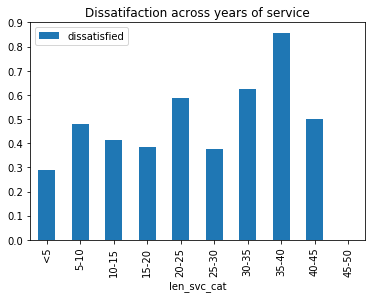

In [130]:
pivot_len_svc.plot(kind = 'bar')
plt.title("Dissatifaction across years of service")

Employees who worked between 35-40 years across both institutes recorded being most dissatisfied at time of resignation.

### Satisfaction_score vs Years of Service (for TAFE only)

In [123]:
pivot_sat_score = resignation_df[resignation_df.institute == 'TAFE'].pivot_table(index = 'len_svc_cat', values = 'satisfaction_score' )

Text(0.5, 1.0, 'Satisfaction score across years of service for TAFE institute')

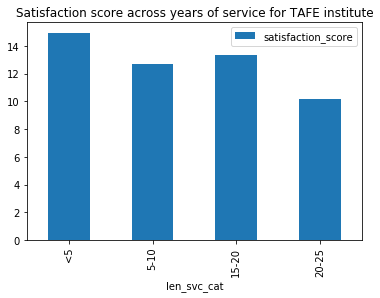

In [124]:
pivot_sat_score.plot(kind = 'bar')
plt.title("Satisfaction score across years of service for TAFE institute");

Again we see that employees who resigned after 5 or less years has least feelings of dissatisfaction, and satisfaction decreases with longer employment.

# Dissatisfaction vs Gender

Text(0.5, 1.0, 'Dissatisfaction vs Gender')

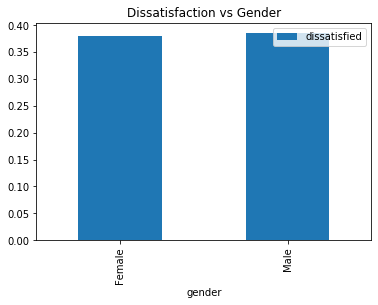

In [152]:
pivot_gender = resignation_df.pivot_table(index = 'gender', values = 'dissatisfied' )
pivot_gender.plot(kind = 'bar')
plt.title('Dissatisfaction vs Gender')

Males and Females seem to be equally dissatisfied, slightly less than 0.5 on the dissatisfaction scale (ranging bet 0 and 1). Males who resign are slight more dissatisfied than females.

# Dissatisfaction vs Age

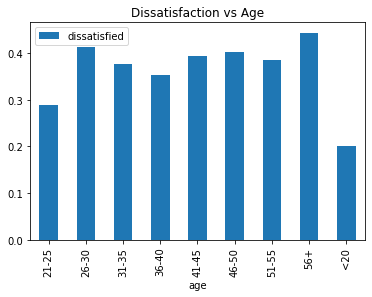

In [264]:
pivot_age = resignation_df.pivot_table(index = 'age', values = 'dissatisfied').sort_values('age')
pivot_age.plot(kind = 'bar')
plt.title('Dissatisfaction vs Age');

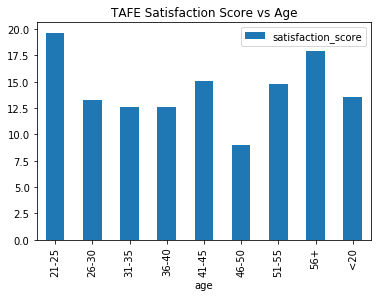

In [156]:
pivot_age_satisfied = resignation_df.pivot_table(index = 'age', values = 'satisfaction_score').sort_values('age')
pivot_age_satisfied.plot(kind = 'bar')
plt.title('TAFE Satisfaction Score vs Age');

Across both institutes, and with only TAFE, youngest employees 25 and under are least dissatisfied. Satisfaction decreases with age.

### Grouping 'age' column further into larger bins

In [111]:
def age_cat(element):
    if pd.isnull(element):
        return np.nan
    elif element == '21-25' or element == '<20':
        return 'young'
    elif element =='26-30' or element == '31-35' or element == '36-40':
        return 'middle-aged'
    else:
        return "mature"

In [112]:
resignation_df['age_cat'] = resignation_df.age.copy()

In [113]:
resignation_df['age_cat'] = resignation_df['age_cat'].apply(age_cat)

Text(0.5, 1.0, 'Dissatisfaction vs Age_cat')

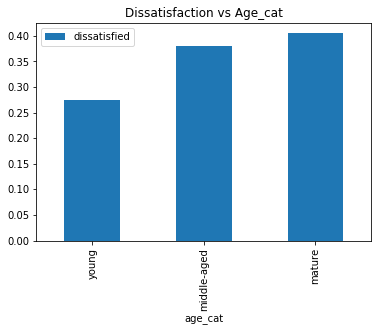

In [114]:
pivot_age_cat = resignation_df.pivot_table(index = 'age_cat', values = 'dissatisfied' )
pivot_age_cat.sort_values('dissatisfied').plot(kind = 'bar')
plt.title("Dissatisfaction vs Age_cat")

Mature employees, i.e. those over 40, are most dissatisfied leading to resignation. Younger employees are least dissatisfied at the time of resignation.

# Dissatisfaction vs Job Position

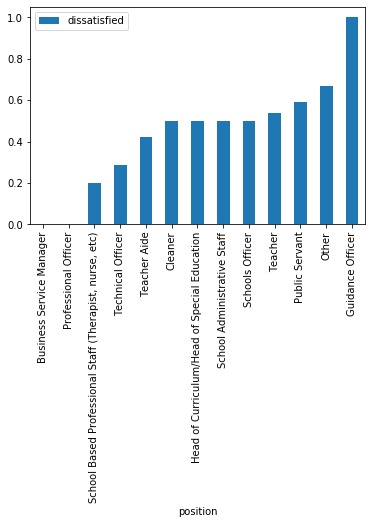

In [115]:
pivot_position = resignation_df.pivot_table(index = 'position', values = 'dissatisfied' )
pivot_position.sort_values('dissatisfied').plot(kind = 'bar')

Although very few Guidance Officers were polled, the graph indicates that all responders were dissatisfied with their jobs at time of resignation. By comparison, Therapists and nurses were most satisfied with their jobs upon resignation.

# CONCLUSION

1) **Length of employment vs Resignation due to dissatisfaction.** Employees who worked at the institutes for a short period of time are least dissatisfied. Employees who worked at institute 30+ years are most dissatisfied, with a decline in dissatisfaction beginning in the 40th year of service.

2) **Gender vs Resignation due to dissatisfaction.** Males and Females seem to be equally dissatisfied at time of resignation and survey taking.

    
3) **Employee age vs Resignation due to dissatisfaction.** Young employees are least dissatisfied, and mature employees (40 yrs and older) are more dissatisfied at the point of resignation.

4) **Job position vs Resignation due to dissatisfaction.** Guidance Officers are most dissatisfied with their jobs, whereas Therapists and Nurses score lower on the dissatisfaction scale.
    
**POSSIBLE ACTIONS TO BE TAKEN BASED ON ANALYSIS**
    
    Institution might consider offering incentives to who have worked 30 years or more. 
    Professions which have higher dissatisfaction ratings can be given more consideration to boost employee morale and satisfaction.




    
